# PHAS0096: A Universe Census of Galaxies
_Manasvee Saraf_ 

Supervisor: Dr. Benjamin Joachimi 

In [3]:
# plot figures embedded in the notebook
%matplotlib inline

# FOR SCHECHTER
from scipy.optimize import curve_fit

# FOR PLOTTING
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib

# FOR ERRORS
from kmeans_radec import KMeans, kmeans_sample
import kmeans_radec

# FOR MATH
import numpy as np

# FOR FINDING LUMINOSITY/COMOVING DISTANCES
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

### Magnitude Data Reduction

#### Maggy
$$ f = 10^{\frac{m}{-2.5}}$$

In [4]:
# MAGGY FROM APPARENT MAGNITUDES
def get_maggy(app_mag_list):
    """
    Argument: 
    (1) numpy array of all apparent magnitude values
    Return: 
    (1) numpy array of all correspoding maggy values
    """
    maggies_list = 10**(app_mag_list / (-2.5))
    return maggies_list

In [5]:
get_maggy(np.array([10,100,20]))

array([1.e-04, 1.e-40, 1.e-08])

#### Inverse variance of maggy
Conversion to the inverse variances from the maggies and the magnitude errors:
$$ \sigma^{-2}_{f} = (0.4 \ln(10)f\sigma_{m})^{-2}$$

In [4]:
# MAGGY INVERSE VARIANCE FROM MAGGY AND APPARENT MAGNITUDES ERRORS
def get_maggy_inv_var(maggies_list, app_mag_err_list):
    """
    Argument: 
    (1) numpy array of all maggy values
    (2) numpy array of all correspoding errors on apparent magnitude values
    Return: 
    (1) numpy array of all correspoding maggy inverse variance values 
    """

    inv_var_list = (0.4 * np.log(10) * maggies_list * app_mag_err_list)**(-2)
    return inv_var_list

In [5]:
get_maggy_inv_var(np.array([1.e-4, 1.e-40, 1.e-8]),np.array([1.e-4, 1.e-4, 1.e-4]))

array([1.17882311e+16, 1.17882311e+88, 1.17882311e+24])

#### Rest-frame magnitude
$$ M = m - 5log_{10}d_{L}(z) - 25 - K(z;z_{0}) $$
where
#### K-corrections
$$ K(z;z_{0}) = −2.5 log10\left(\frac{f}{f_{z_{0}}}\right)$$

In [6]:
# REST-FRAME MAG FROM APPARENT MAG, REDSHIFTS AND MAGGY RATIOS
def get_rest_mag(redshift_list, app_mag_list, maggy_ratio_list):
    """
    Arguments: 
    (1) numpy array of all redshifts
    (2) numpy array of all corresponding apparent magnitudes
    (3) numpy array of all corresponding maggy ratios
    Return: 
    (1) numpy array of all corresponding rest-frame magnitudes
    """

    # calculate luminosity distance
    lum_dist_list = cosmo.luminosity_distance(redshift_list).value
    print('\tLuminosity distance calculated.')

    # calculate abs mag
    abs_mag_list = app_mag_list - (5 * np.log10(lum_dist_list)) - 25
    print('\tAbsolute magnitude calculated.')

    # calculate K corrections
    Kcorr_list = -2.5 * np.log10(maggy_ratio_list)
    print('\tK-corrections calculated.')

    # calculate rest mag
    rest_mag_list = abs_mag_list - Kcorr_list
    print('\tRest-frame magnitude calculated.')

    return rest_mag_list

In [7]:
get_rest_mag(np.array([0.1, 0.2, 0.3]), np.array([-18, -19, -20]),
             np.array([0.7, 0.8, 0.9]))

	Luminosity distance calculated.
	Absolute magnitude calculated.
	K-corrections calculated.
	Rest-frame magnitude calculated.


array([-56.70244042, -59.19851686, -61.06979436])

### The $1/V_{max}$ weighted Luminosity Function

#### Comoving Volume
$$V_{C} = \frac{\omega}{3}[cmd(z)]^{3}$$
where $\omega$ is the survey's area is steradians.

In [8]:
# VOLUME FROM SURVEY AREA AND REDSHIFT VALUES
def get_volume(survey_area, redshift_list):
    """
    Arguments:
    (1) float value of survey area in sq. deg. 
    (2) numpy array of all redshifts
    Return: 
    (1) numpy array of all corresponding comoving volumes
    """

    # calculate comoving distance
    com_dist_list = cosmo.comoving_distance(redshift_list).value
    print('\tComoving distance calculated.')

    # convert survey area to steradian
    survey_steradian = survey_area * ((np.pi / 180.)**2)
    print('\tSurvey area converted.')

    # calculate comoving volume
    vol_list = (com_dist_list**3) * (survey_steradian / 3)
    print('\tComoving volume calculated.')

    return vol_list

In [9]:
get_volume(100.0, np.array([1, 2, 3]))

	Comoving distance calculated.
	Survey area converted.
	Comoving volume calculated.


array([3.66072279e+08, 1.41050409e+09, 2.60516393e+09])

#### Binning and weighting counts

Binning into equal luminosity bins. Then weighting the number of galaxies by inverse of comoving volume. 

In [10]:
# PHI FROM REST-FRAME MAG AND MAXIMUM GALAXY VOLUME VALUES AND NUMBER OF BINS
def get_binned_phi(rest_mag_list, Vmax_list, n_mag_bins):
    """
    Arguments:
    (1) numpy array of all rest-frame magnitudes
    (2) numpy array of all corresponding maximum volumes
    (3) integer value of number of magnitude bins required
    Return:
    (1) numpy array of mid-magnitude (i.e. x) value of each bin
    (2) numpy array of magnitude-width/2 (i.e. x-error) value of each bin
    (3) numpy array of phi (i.e. y) value of each bin (with h = 0.7)
    """

    # get bin_edges for diving the rest_mags in n_bins
    counts, bin_edges = np.histogram(rest_mag_list, bins=n_mag_bins)

    # sort rest_mag and Vmax lists per increasing mag
    sorted_index = np.argsort(rest_mag_list)
    sorted_Vmax_list = np.array(Vmax_list)[sorted_index]
    sorted_rest_mag_list = np.sort(rest_mag_list)

    # ceate empty lists for mid_M, phi and M_err
    mid_M_list = np.empty(n_mag_bins)
    M_err_list = np.empty(n_mag_bins)
    phi_list = np.empty(n_mag_bins)

    # loop over each bin
    for i in range(n_mag_bins):

        # find min and max M of bin
        max_M = bin_edges[i + 1]
        min_M = bin_edges[i]

        # add mid_M to list
        mid_M_list[i] = (min_M + max_M) / 2

        # add M_err to list
        M_err_list[i] = (abs(min_M) - abs(max_M)) / 2

        # find indicies upto the max_M
        up_lim_indices = np.where(sorted_rest_mag_list <= max_M)[0]

        # limit M and Vmax corresponding to max_M
        up_lim_rest_mag_list = sorted_rest_mag_list[up_lim_indices]
        up_lim_Vmax_list = sorted_Vmax_list[up_lim_indices]

        # find indicies from min_M to max_M value of bin
        if i != 0:
            lim_indices = np.where(up_lim_rest_mag_list > min_M)[0]
        else:
            lim_indices = np.where(up_lim_rest_mag_list >= min_M)[0]

        # limit Vmax corresponding from min_M to max_M
        Vmax_values = up_lim_Vmax_list[lim_indices]

        # calculate 1/Vmax
        phi_values = np.reciprocal(Vmax_values)
        # sum 1/Vmax all in this bin
        phi = sum(phi_values)

        # convert 1/Vmax to phi and add to list
        h = 0.7
        phi_list[i] = phi * ((h)**3) / M_err_list[i]

    return mid_M_list, M_err_list, phi_list

In [11]:
get_binned_phi(np.array([-18, -19, -19, -19, -18, -19, -20]),
               np.array([3e8, 4e8, 5e8, 4e8, 5e8, 4e8, 5e8]), 5)

(array([-19.8, -19.4, -19. , -18.6, -18.2]),
 array([0.2, 0.2, 0.2, 0.2, 0.2]),
 array([3.43000000e-09, 0.00000000e+00, 1.62925000e-08, 0.00000000e+00,
        9.14666667e-09]))

### Error on the $1/V_{max}$ weighted Luminosity Function

#### Dividing survey area into equal patches

In [12]:
# LABELS FOR PATCHES FROM RA, DEC, NUMBER OF PATCHES AND CENTER GUESSES
def get_patches(RA_list,
                DEC_list,
                n_patches,
                center_guesses,
                survey='kids',
                numba_installed=True,
                plot_savename='none'):
    """
    Arguments:
    (1) numpy array of all RA values
    (2) numpy array of all corresponding Dec values
    (3) integer value of number of patches required
    (4) (n_patches, 2) numpy array of patch center guesses [RA,Dec]
    (5) string with survey name
        only change if survey area covers/connects over 320 degree RA
        and does not connect over 360 to 0 degree RA
    (6) Boolean - mark as False if numba is not installed
    (7) string with name and extension to save plot as
    Return: 
    (1) numpy array of patch assignment labels for each RA entry
    """

    # MAKE SURE ALL PATCHES ARE SITCHED ON SKY
    # works for most surveys - GAMA, KiDS - check rest
    if survey == 'kids':
        corrected_RA_list = np.where(RA_list > 320., RA_list - 360., RA_list)
    # use if a survey patch covers/connects over 320 degrees RA
    # and does not connect over 360 to 0 degree RA
    if survey != 'kids':
        corrected_RA_list = RA_list

    # STACK RA AND DEC AS X
    X = np.column_stack((corrected_RA_list, DEC_list))

    # FIND LABELS TO DIVIDE X INTO EQUAL n_patches
    if numba_installed:
        km = KMeans(center_guesses, method='fast')
    else:
        km = KMeans(center_guesses)
    labels = km.find_nearest(X)

    # VISUALISE ON PLOT
    colors = cm.tab20(np.linspace(0, 1, n_patches))
    plt.figure(figsize=(10, 10))
    plt.suptitle("Galaxy Patches", fontsize=20)

    # get patch counts on histogram
    plt.subplot(211)
    plt.grid(True)
    N, b, p = plt.hist(labels, bins=n_patches)
    for n in range(n_patches):
        p[n].set_facecolor(colors[n])
    plt.xlabel("Label", fontsize=20)
    plt.ylabel("Count", fontsize=20)

    # get patches on sky
    plt.subplot(212)
    for n in range(n_patches):
        plt.grid(True)
        subset_indices = np.where(labels == n)
        plt.scatter(corrected_RA_list[subset_indices],
                    DEC_list[subset_indices],
                    color=colors[n],
                    s=1)
        # if 'gama' in datasetname:
            # plt.xlim(120, 240)
            # plt.ylim(-10, 10)
        # if 'kids' in datasetname:
            # plt.xlim(-50, 250)
            # plt.ylim(-40, 10)
        plt.xlabel("RA(J2000)/ deg", fontsize=20)
        plt.ylabel("Dec(J2000)/ deg", fontsize=20)

    if plot_savename != 'none':
        plt.savefig(plot_savename, dpi=300)
    plt.show()

    return labels

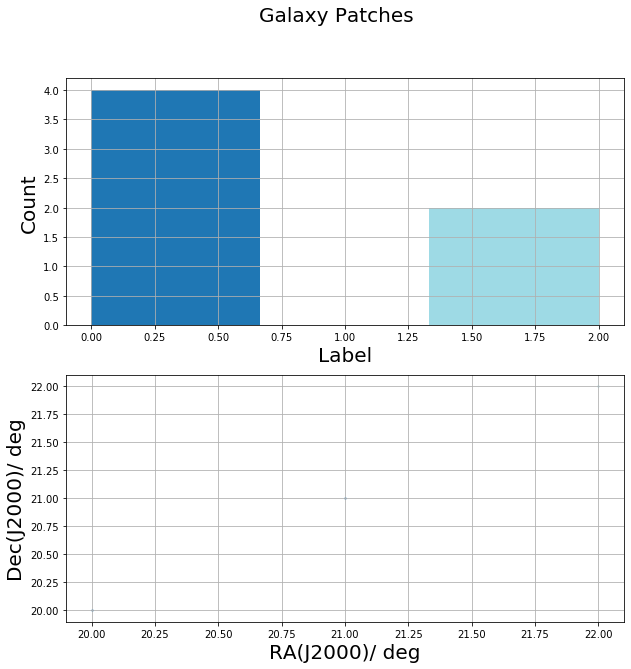

array([0, 0, 2, 0, 0, 2])

In [13]:
get_patches(np.array([20, 21, 22, 20, 21, 22]),
            np.array([20, 21, 22, 20, 21, 22]),
            3,
            np.array([[20, 21], [22, 20], [21, 22], [20, 21], [22, 20],
                      [21, 22]]),
            survey='kids',
            numba_installed=True,
            plot_savename='none')

#### Errors on $\phi$ values

In [14]:
# PHI ERROR FROM REST-FRAME MAG, MAXIMUM GALAXY VOLUME VALUES, LABELS, NUMBER OF PATCHES AND NUMBER OF BINS
def get_binned_phi_error(rest_mag_list, Vmax_list, labels, n_patches,
                         n_mag_bins):
    """
    Arguments:
    (1) numpy array of all rest-frame magnitudes
    (2) numpy array of all corresponding maximum volumes
    (3) numpy array of all corresponding patch assignment labels
    (4) integer value of number of patches required
    (5) integer value of number of magnitude bins required
    Return: 
    (1) numpy array of phi error (i.e. y-error) value of each bin
    """

    # GET PHI VALUES USING ONLY VALUES IN EACH PATCH
    patch_phis = []
    for n in range(n_patches):
        patch_indices = np.where(labels == n)
        patch_M = rest_mag_list[patch_indices]
        patch_Vmax = Vmax_list[patch_indices] / n_patches
        mid_M_list, M_err_list, phi_list = get_binned_phi(
            patch_M, patch_Vmax, n_mag_bins)
        patch_phis.append(phi_list)

    # STANDARD ERRORS ON PHI VALUES BETWEEN EACH PATCH
    phi_err_list = np.std(patch_phis, axis=0)

    return phi_err_list

In [15]:
get_binned_phi_error(np.array([-18, -19, -19, -19, -18, -19, -20]),
                     np.array([3e8, 4e8, 5e8, 4e8, 5e8, 4e8, 5e8]),
                     np.array([1, 1, 2, 2, 3, 3, 1]), 3, 5)

array([4.85075252e-09, 0.00000000e+00, 1.95163685e-08, 0.00000000e+00,
       8.08458753e-09])

### Model Luminosity Function 

#### Schechter Function

$$\phi(M) = \frac{2}{5}\ln(10)e^{-10^{\frac{2}{5}(M_{*}-M)}}\left( \phi^{*}10^{\frac{2}{5}(M_{*}-M)(\alpha+1)}\right)$$

In [16]:
# SCHECHTER PHI FROM REST-FRAME MAG AND 3 FREE PARAMETERS OF MODEL
def SchechterMagModel(M_list, M_star, phi_star, alpha):
    """
    Arguments:
    (1) numpy array of magnitudes (i.e. x)
    (2) float value of parameter M_star 
    (3) float value of parameter phi_star
    (4) float value of parameter alpha
    Return: 
    (1) numpy array of Schechter modelled phi (i.e. y)
    """

    # FACTOR
    factor = (2 / 5) * np.log(10)

    # POWER
    Mstar_Mlist = M_star - M_list
    power = (2 / 5) * Mstar_Mlist

    # PART 1
    power1 = -10**(power)
    part1 = np.exp(power1)

    # PART 2
    index = alpha + 1
    power2 = power * index
    part2 = phi_star * 10**(power2)

    # PHI(M)
    phi_list = factor * part1 * part2

    return phi_list

In [17]:
SchechterMagModel(
    np.array([
        -24.69729828, -24.0952858, -23.49327332, -22.89126084, -22.28924836,
        -21.68723587, -21.08522339, -20.48321091, -19.88119843, -19.27918595,
        -18.67717347, -18.07516099, -17.4731485, -16.87113602
    ]), -20.71, 10**(-2.02), -1.26)

array([2.76127225e-20, 5.98436064e-13, 1.04045498e-08, 3.01534183e-06,
       8.32068891e-05, 5.94810994e-04, 1.95735209e-03, 4.12510635e-03,
       6.73048344e-03, 9.48009623e-03, 1.22718071e-02, 1.51335765e-02,
       1.81500052e-02, 2.14221579e-02])

#### Double Schechter Function

$$\phi(M) = \frac{2}{5}\ln(10)e^{-10^{\frac{2}{5}(M_{*}-M)}}\left[\left( \phi_{1}^{*}10^{\frac{2}{5}(M_{*}-M)(\alpha_{1}+1)}\right)+\left( \phi_{2}^{*}10^{\frac{2}{5}(M_{*}-M)(\alpha_{2}+1)}\right)\right]$$

In [18]:
def DoubleSchechterMagModel(M_list, M_star, phi_star1, alpha1, phi_star2,
                            alpha2):
    """
    Arguments:
    (1) numpy array of magnitudes (i.e. x)
    (2) float value of parameter M_star 
    (3) float value of parameter phi_star_1
    (4) float value of parameter alpha_1
    (5) float value of parameter phi_star_2
    (6) float value of parameter alpha_2
    Return: 
    (1) numpy array of Double Schechter modelled phi (i.e. y)
    """

    # FACTOR
    factor = (2 / 5) * np.log(10)

    # POWER
    Mstar_Mlist = M_star - M_list
    power = (2 / 5) * Mstar_Mlist

    # PART 1
    power1 = -10**(power)
    part1 = np.exp(power1)

    # PART 2
    index1 = alpha1 + 1
    power2 = power * index1
    part2 = phi_star1 * 10**(power2)

    # PART 3
    index2 = alpha2 + 1
    power3 = power * index2
    part3 = phi_star2 * 10**(power3)

    # PHI(M)
    phi_list = factor * part1 * (part2 + part3)

    return phi_list

In [19]:
DoubleSchechterMagModel(-19, -20.71, 0.00955, -1.26, 0.009, -1.3)

0.02157964300345554

### Goodness of Fit
#### $\chi^{2}$
$$\chi^{2} = \sum_{i}\left(\frac{O_{i}-C_{i}}{\sigma_{i}}\right)^{2}$$

#### Degrees of freedom, $\nu$
$$\nu =  n - m $$
where $n$ is the number of observations $O_{i}$, and $m$ is the number of parameters used to fit $C_{i}$.

#### Reduced $\chi^{2}$
$$\chi_{\nu}^{2} = \frac{\chi^{2}}{\nu}$$

In [20]:
# REDUCED CHI SQUARED GOODNESS OF FIT PARAMETER
def get_gof(obs, err, exp, m):
    """
    Arguments:
    (1) numpy array of observed values (phi from the 1/Vmax estimator)
    (2) numpy array of errors on observed values
    (3) numpy array of expected values (phi from the Schechter function)
    (4) integer value of number of parameters used to calculate the expected values
    Return: 
    (1) float value of reduced chi square
    """

    residuals = obs - exp
    rBYerr = residuals / err
    rBYerr_sq = rBYerr**2
    chi_sq = np.sum(rBYerr_sq)

    dof = len(obs) - m

    red_chi_sq = chi_sq / dof

    return red_chi_sq

In [21]:
get_gof(
    np.array([
        8.05551125e-07, 3.88006185e-06, 3.69629802e-05, 1.89598594e-04,
        4.05468514e-04, 6.72676369e-04, 9.09832025e-04, 1.11367139e-03,
        1.48211046e-03, 2.49173629e-03, 3.51558199e-03, 3.72147189e-03,
        5.01716103e-03, 7.55817685e-03
    ]),
    np.array([
        2.61759783e-07, 1.25718317e-06, 9.52799069e-06, 3.89147050e-05,
        8.49777323e-05, 1.39651245e-04, 2.00190843e-04, 2.57083205e-04,
        3.95215518e-04, 6.88821910e-04, 1.10196321e-03, 1.17736050e-03,
        1.39659137e-03, 2.17712916e-03
    ]),
    np.array([
        1.61215514e-07, 5.04366709e-06, 4.02522675e-05, 1.46575206e-04,
        3.40094001e-04, 6.09135865e-04, 9.40278126e-04, 1.33262944e-03,
        1.79828886e-03, 2.35924799e-03, 3.04550799e-03, 3.89501555e-03,
        4.95495910e-03, 6.28404405e-03
    ]), 3)

1.002726586928289

#### Best-fitting and plots

In [22]:
# BEST FIT SCHECHTER PHI AND REDUCED CHI SQUARED ESTIMATE


def get_schechter_phi(M_list,
                      M_err_list,
                      phi_list,
                      phi_err_list,
                      guesses,
                      plot_savename='none'):
    """
    Arguments:
    (1) numpy array of mid magnitude (i.e. x) value of each bin
    (2) numpy array of magnitudes error (i.e. x-error) value of each bin
    (3) numpy array of phi (i.e. y) value of each bin
    (4) numpy array of phi error (i.e. y-error) value of each bin
    (5) numpy array of Schechter paramater guesses in order [M_star, phi_star, aplha]
    (6) string with name and extension to save plot as
    Return:
    (1) numpy array of Schechter modelled phi (i.e. y)
    (2) float value of reduced chi square of the fit
    (3) float value of fit parameter M_star 
    (4) float value of error on fit parameter M_star
    (5) float value of fit parameter phi_star
    (6) float value of error on fit parameter phi_star
    (7) float value of fit parameter alpha
    (8) float value of error on fit parameter alpha
    """

    popt, pcov = curve_fit(SchechterMagModel,
                           M_list,
                           phi_list,
                           p0=guesses,
                           sigma=phi_err_list)

    perr = np.sqrt(np.diag(pcov))

    M_star = popt[0]
    M_star_err = perr[0]
    phi_star = popt[1]
    phi_star_err = perr[1]
    alpha = popt[2]
    alpha_err = perr[2]

    model_phi_list = SchechterMagModel(M_list, M_star, phi_star, alpha)

    m = 3
    red_chi_sq = get_gof(phi_list, phi_err_list, model_phi_list, m)

    if plot_savename != 'none':

        plt.figure(figsize=(10, 10))

        # plot data
        plt.errorbar(M_list,
                     phi_list,
                     xerr=M_err_list,
                     yerr=phi_err_list,
                     fmt='cx',
                     mec='k',
                     label='Survey data')

        # plot model
        plt.plot(
            M_list,
            model_phi_list,
            'b--',
            label='Schechter, alpha: {0:.4f} $\pm$ {1:.4f}, $\chi^{2}$: {3:.4f}'
            .format(alpha, alpha_err, 2, red_chi_sq))

        # plot turning point
        plt.errorbar(
            M_star,
            phi_star,
            xerr=M_star_err,
            yerr=phi_star_err,
            fmt='b*',
            mec='c',
            label=
            '$M^{0}$: {1:.4f} $\pm$ {2:.4f}, $\phi^{3}$: {4:.4f} $\pm$ {5:.4f}'
            .format('*', M_star, M_star_err, '*', phi_star, phi_star_err))

        plt.yscale('log')
        # plt.xlim(-26, -12)
        # plt.ylim(1e-8, 0.9)
        plt.xlabel("rest-frame r-magnitude/ $(M_{r})_{cal}$/ mag", fontsize=20)
        plt.ylabel(
            "number density / $\Phi (M_{r})/ h_{70}^{3}Mpc^{-3}mag^{-1}$",
            fontsize=20)
        # plt.title(title, fontsize=20)
        plt.grid(True)
        plt.legend(loc='upper left')

        plt.savefig(plot_savename, dpi=300)

        plt.show()

    return model_phi_list, red_chi_sq, M_star, M_star_err, phi_star, phi_star_err, alpha, alpha_err

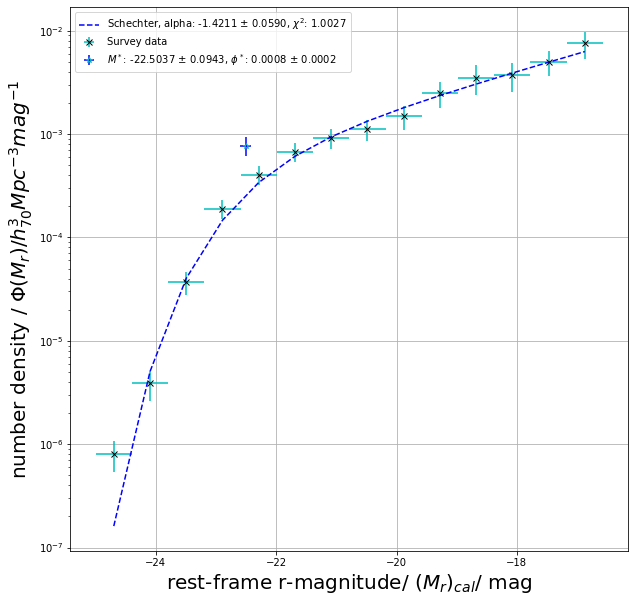

(array([1.61215514e-07, 5.04366709e-06, 4.02522675e-05, 1.46575206e-04,
        3.40094001e-04, 6.09135865e-04, 9.40278126e-04, 1.33262944e-03,
        1.79828886e-03, 2.35924799e-03, 3.04550799e-03, 3.89501555e-03,
        4.95495910e-03, 6.28404405e-03]),
 1.0027265882003165,
 -22.503720321424872,
 0.09432695752449195,
 0.000772050032397016,
 0.00015469515652665115,
 -1.421095921941838,
 0.05904809451072723)

In [23]:
get_schechter_phi(
    np.array([
        -24.69729828, -24.0952858, -23.49327332, -22.89126084, -22.28924836,
        -21.68723587, -21.08522339, -20.48321091, -19.88119843, -19.27918595,
        -18.67717347, -18.07516099, -17.4731485, -16.87113602
    ]),
    np.array([
        0.30100624, 0.30100624, 0.30100624, 0.30100624, 0.30100624, 0.30100624,
        0.30100624, 0.30100624, 0.30100624, 0.30100624, 0.30100624, 0.30100624,
        0.30100624, 0.30100624
    ]),
    np.array([
        8.05551125e-07, 3.88006185e-06, 3.69629802e-05, 1.89598594e-04,
        4.05468514e-04, 6.72676369e-04, 9.09832025e-04, 1.11367139e-03,
        1.48211046e-03, 2.49173629e-03, 3.51558199e-03, 3.72147189e-03,
        5.01716103e-03, 7.55817685e-03
    ]),
    np.array([
        2.61759783e-07, 1.25718317e-06, 9.52799069e-06, 3.89147050e-05,
        8.49777323e-05, 1.39651245e-04, 2.00190843e-04, 2.57083205e-04,
        3.95215518e-04, 6.88821910e-04, 1.10196321e-03, 1.17736050e-03,
        1.39659137e-03, 2.17712916e-03
    ]),
    np.array([-20.71, 10**(-2.02), -1.26]),
    plot_savename='test.png')